In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data):
        features = data[['rssi', 'connected_devices', 'distance_meters', 'num_walls']].values
        self.features = StandardScaler().fit_transform(features).astype(np.float32)
        self.labels = LabelEncoder().fit_transform(data['gesture'])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx], dtype=torch.long)


In [ ]:
# Load the data
data = pd.read_json('/content/drive/MyDrive/Sample_RSSI_3.json')

# Convert relevant columns to numeric
columns_to_convert = ['rssi', 'connected_devices', 'distance_meters', 'num_walls']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric)

# Step 2: Split Data into Train and Test Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_dataset = GestureDataset(train_data)
test_dataset = GestureDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)


Epoch [1/1000], Loss: 2.0899, Training Accuracy: 15.80%
Validation Accuracy after Epoch 1: 29.46%
Epoch [2/1000], Loss: 1.9588, Training Accuracy: 23.23%
Validation Accuracy after Epoch 2: 30.55%
Epoch [3/1000], Loss: 1.8360, Training Accuracy: 30.18%
Validation Accuracy after Epoch 3: 36.57%
Epoch [4/1000], Loss: 1.7383, Training Accuracy: 34.38%
Validation Accuracy after Epoch 4: 39.84%
Epoch [5/1000], Loss: 1.6535, Training Accuracy: 36.78%
Validation Accuracy after Epoch 5: 43.62%
Epoch [6/1000], Loss: 1.5663, Training Accuracy: 39.39%
Validation Accuracy after Epoch 6: 45.33%
Epoch [7/1000], Loss: 1.4916, Training Accuracy: 40.92%
Validation Accuracy after Epoch 7: 49.27%
Epoch [8/1000], Loss: 1.4239, Training Accuracy: 42.87%
Validation Accuracy after Epoch 8: 48.76%
Epoch [9/1000], Loss: 1.3621, Training Accuracy: 44.08%
Validation Accuracy after Epoch 9: 48.09%
Epoch [10/1000], Loss: 1.3264, Training Accuracy: 44.89%
Validation Accuracy after Epoch 10: 50.22%
Epoch [11/1000], L

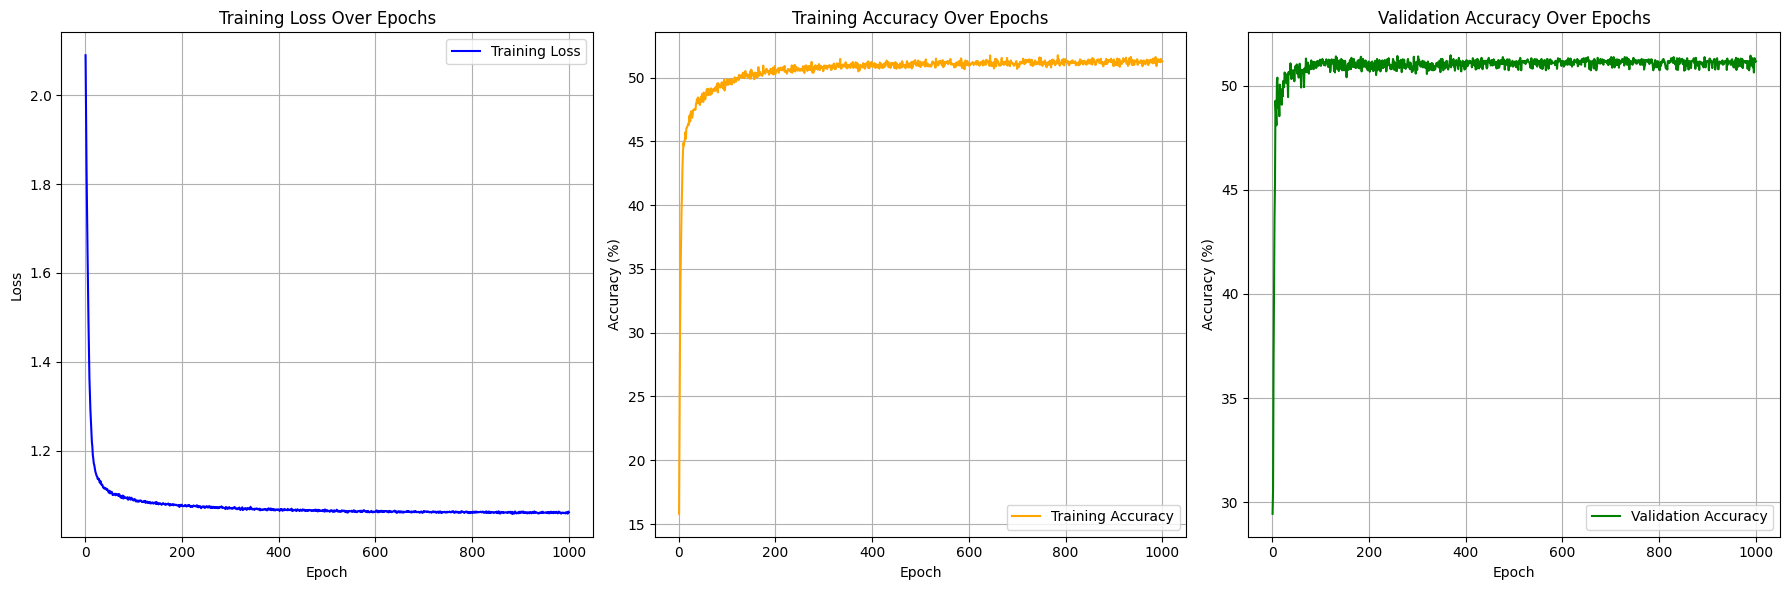

In [3]:
# Step 3: Define an improved GRU-based Neural Network Model to increase accuracy
class GestureGRU(nn.Module):
    def __init__(self, input_size=4, hidden_size=400, num_layers=5, num_classes=7):
        super(GestureGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.4, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 512),  # Expanded layer sizes for better feature learning
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x, _ = self.gru(x)  # GRU output
        x = x[:, -1, :]  # Take the output from the last time step
        x = self.fc(x)
        return x


# Step 4: Training the Model with Logging
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GestureGRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Increased learning rate and reduced weight decay
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=600, anneal_strategy='linear')

num_epochs = 1000
train_losses = []
val_accuracies = []

best_val_accuracy = 0.0
patience_counter = 0
patience_limit = 15  # Early stopping if validation accuracy does not improve for 15 epochs
save_path = 'C:\\Users\\kunte\\Desktop\\capstone\\best_model_weights.pkl'  # Path to save the best model in PKL format

# Initialize lists to store training and validation accuracy
train_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Training accuracy for this epoch
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation Phase
    model.eval()
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.2f}%")

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        with open(save_path, 'wb') as f:
            pickle.dump(model.state_dict(), f)

# Plotting Training Loss, Training Accuracy, and Validation Accuracy over Epochs
plt.figure(figsize=(18, 6))

# Training Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Training Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, color='orange', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.grid(True)
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
